In [1]:
"""
Created on: Fri. 14 Oct. 2022
Updated on: Wed. 2 Nov. 2022
Author: Mélina Verger

Compute UT, d and delta metrics (cf. report).
"""

# To exit script
from sys import exit

# To load the trained models
import pickle

# For data manipulation
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

# To print with tabular format
from tabulate import tabulate

# Plotting module
import matplotlib.pyplot as plt

## Loading

In [2]:
DATA = pickle.load(open("../data/DATA", "rb"))
SPLIT = pickle.load(open("../data/SPLIT", "rb"))
SFEATURES = pickle.load(open("../data/SFEATURES", "rb"))

print(DATA)
print(SPLIT)
print(SFEATURES)

stInfo
7030
['gender', 'imd_band', 'disability']


In [3]:
# Load test sets

X_test = pd.read_csv("../data/X_test" + "_" + DATA + "_" + SPLIT + ".csv")
y_test = pd.read_csv("../data/y_test" + "_" + DATA + "_" + SPLIT + ".csv")

In [4]:
# Load trained models

clf_lr = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_lr", "rb"))
# clf_svc = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_svc", "rb"))
clf_knearest = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_knearest", "rb"))
clf_dt = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_dt", "rb"))
clf_rf = pickle.load(open("../models/" + DATA + "_" + SPLIT + "_clf_rf", "rb"))

In [5]:
models = [clf_lr, clf_knearest, clf_dt, clf_rf]  # except svc

## Separate data sets by (un-)protected groups

/!\ The following only works for binary sensitive features.

In [6]:
dict_subsets_test = dict()

for sensfeat in SFEATURES:
    # X_test_{sensitive feature and group 1/0}
    dict_subsets_test["X"+ "_test_" + sensfeat + "_"+ "1"] = X_test[X_test[sensfeat] == 1]
    dict_subsets_test["X"+ "_test_" + sensfeat + "_"+ "0"] = X_test[X_test[sensfeat] == 0]
    # y_test_{sensitive feature and group 1/0}
    dict_subsets_test["y"+ "_test_" + sensfeat + "_"+ "1"] = y_test.loc[dict_subsets_test["X" + "_test_" + sensfeat + "_" + "1"].index]
    dict_subsets_test["y"+ "_test_" + sensfeat + "_"+ "0"] = y_test.loc[dict_subsets_test["X" + "_test_" + sensfeat + "_" + "0"].index]

## Prediction **probabilities**

In [7]:
dict_subsets_PP = dict()

for model in models:  # except svc model because no probability outputs 

    if model == clf_lr:
        modl = "lr"
    elif model == clf_knearest:
        modl = "kn"
    elif model == clf_dt:
        modl = "dt" 
    elif model == clf_rf:
        modl = "rf"
    else:
        print("Invalid model.")
        exit()

    # y_PP for X_test_{sensitive feature and group 1/0}
    for sensfeat in SFEATURES:
        dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "1"] = model.predict_proba(dict_subsets_test["X"+ "_test_" + sensfeat + "_"+ "1"])[:, 1]  # [:, 1] because propa of being in the class 1
        dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "0"] = model.predict_proba(dict_subsets_test["X"+ "_test_" + sensfeat + "_"+ "0"])[:, 0]  # [:, 1] because propa of being in the class 0

## UT

In [8]:
results = list()

for sensfeat in SFEATURES:

    for model in models:

        if model == clf_lr:
            modl = "lr"
        elif model == clf_knearest:
            modl = "kn"  # model that generates FutureWarning
        elif model == clf_dt:
            modl = "dt" 
        elif model == clf_rf:
            modl = "rf"
        else:
            print("Invalid model.")
            exit()
        
        subres = list()
        subres.append(sensfeat)
        subres.append(modl)
        moy1 = np.mean(dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "1"])
        moy0 = np.mean(dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "0"])
        ut = abs(moy1 - moy0)
        subres.append(round(ut, 2))
        subres.append(round(moy1, 2))
        subres.append(round(moy0, 2))
        results.append(subres)

print(tabulate(results, headers=["Sensitive feature", "Model", "   UT      ", "(Mean group 1)", "(Mean group 0)"]))

Sensitive feature    Model         UT          (Mean group 1)    (Mean group 0)
-------------------  -------  -------------  ----------------  ----------------
gender               lr                0.26              0.62              0.36
gender               kn                0.26              0.63              0.37
gender               dt                0.28              0.65              0.36
gender               rf                0.27              0.63              0.36
imd_band             lr                0.3               0.58              0.28
imd_band             kn                0.31              0.54              0.23
imd_band             dt                0.31              0.58              0.27
imd_band             rf                0.31              0.58              0.27
disability           lr                0.23              0.59              0.36
disability           kn                0.29              0.67              0.38
disability           dt                0

## Mean density error ($\overline{d}$)

/!\ The vectors does not have the same length but it is handled by the density vector.

In [9]:
def normalized_density_vector(pred_proba_array):

    PP_rounded = np.around(pred_proba_array, decimals=2)

    density_vector = np.zeros(101)  # empty
    proba_values = np.linspace(0, 1, 101)  # 101 elems

    for i in range(len(proba_values)):
        compar = proba_values[i]
        count = 0
        for x in PP_rounded:
            if x == compar:
                count = count + 1
        density_vector[i] = count
    
    normalized_density_vec = density_vector / np.sum(density_vector)

    return normalized_density_vec

In [10]:
def mean_density_error(norm_densvect_1, norm_densvect_0):
    return np.absolute(norm_densvect_1 - norm_densvect_0).sum()

In [11]:
d_res = list()

for sensfeat in SFEATURES:

    for model in models:

        if model == clf_lr:
            modl = "lr"
        elif model == clf_knearest:
            modl = "kn"  # model that generates FutureWarning
        elif model == clf_dt:
            modl = "dt" 
        elif model == clf_rf:
            modl = "rf"
        else:
            print("Invalid model.")
            exit()
    
        d_subres = list()
        d_subres.append(sensfeat)
        d_subres.append(modl)
        norm_densvect1 = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "1"])
        norm_densvect0 = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "0"])
        d = round(mean_density_error(norm_densvect1, norm_densvect0), 2)
        d_subres.append(d)
        d_res.append(d_subres)

print(tabulate(d_res, headers=["Sensitive feature", "Model", "  d     "]))

Sensitive feature    Model        d
-------------------  -------  ----------
gender               lr             1.73
gender               kn             0.92
gender               dt             1.58
gender               rf             1.72
imd_band             lr             1.88
imd_band             kn             1.11
imd_band             dt             1.62
imd_band             rf             1.73
disability           lr             1.76
disability           kn             0.94
disability           dt             1.52
disability           rf             1.56


## Number of peaks

In [12]:
# height is for the amplitude of the peak
# threshold is for the difference in amplitude between neighbors
# distance is for the horizontal distance between peaks (relevant for periodicity)
# width is for the width of the peak
# prominence is for how much the peak is outstanding from its neighbors (seems to work like heigth), but its definition is : how much height we need to go down the peak before meeting the first highest other peak. https://ressources.labomedia.org/detection_pics_signal C'est-à-dire que pour être un bon pic, le pic doit vraiment monter et redescendre significativement, donc ne pas être noyé dans plusieurs variations instables.
# 

0.01


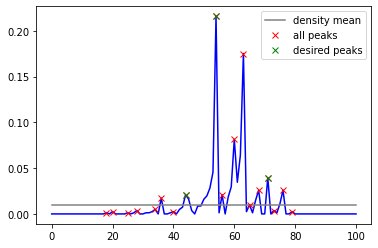

In [55]:
# x = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + modl + "_" + sensfeat + "_" + "1"])
x = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + "lr" + "_" + "imd_band" + "_" + "1"])
peaks, _ = find_peaks(x)  # all peaks (equivalent to height=0 for the peaks)
peaks2, _ = find_peaks(x, height=np.mean(x), distance=10)  # height=np.mean(x) for having all peaks higher than the mean

print(round(np.mean(x), 2))
plt.plot(x, color="blue")
plt.plot([np.mean(x)] * len(x), color="grey", label="density mean")
plt.plot(peaks, x[peaks], "x", color="red", label="all peaks")
plt.plot(peaks2, x[peaks2], "x", color="green", label="desired peaks")
plt.legend()

0.01


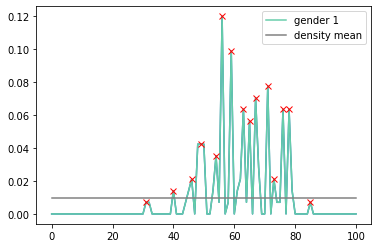

In [28]:
x = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + "lr" + "_" + "gender" + "_" + "1"])
plt.plot(x)
peaks, _ = find_peaks(x, height=0)

print(round(np.mean(x), 2))
plt.plot(x, color="mediumaquamarine", label="gender 1")
plt.plot([np.mean(x)] * len(x), color="grey", label="density mean")
plt.plot(peaks, x[peaks], "x", color="red")
plt.legend()

0.01


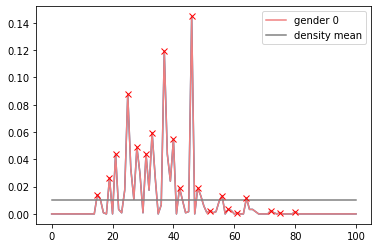

In [29]:
x = normalized_density_vector(dict_subsets_PP["y" + "_PP_" + "lr" + "_" + "gender" + "_" + "0"])
plt.plot(x)
peaks, _ = find_peaks(x, height=0)

print(round(np.mean(x), 2))
plt.plot(x, color="lightcoral", label="gender 0")
plt.plot([np.mean(x)] * len(x), color="grey", label="density mean")
plt.plot(peaks, x[peaks], "x", color="red")
plt.legend()